In [1]:
import pandas
import numpy
import pmdarima as pm
import matplotlib.pyplot as plt
from TimeSeriesModelCreator_Parallel_talos import TimeSeriesModelCreator_Parallel_talos

Using TensorFlow backend.


# Read in dataset and prepare training and testing sets

In [2]:
dataframe = pandas.read_csv(r'..\Datasets\GEANTCombined\all_in_one_complete_appended.csv')
subsets_training = []
subsets_testing = []
for x in range(1,6):
    subsets_training.append(dataframe[(dataframe.source == x) & (dataframe.destination == 11)][['bandwidth']][-(1000+200):-200])
    subsets_testing.append(dataframe[(dataframe.source == x) & (dataframe.destination == 11)][['bandwidth']][-200:])

# Creating LSTM and training

In [3]:
creator = TimeSeriesModelCreator_Parallel_talos(1, r'..\Datasets\GEANTCombined\all_in_one_complete_appended.csv')
modelMatch = {}
for x in range(1,6):
    creator.add_new_model(name = 'test'+str(x), nodes = 32, layer = 3, loss='mean_squared_error', optimizer='adam')
    modelMatch[str(x)+'_11'] = 'test'+str(x)
creator.train_model(1, 5, 11, 11, 1000, 200, modelMatch, 8, 1, 0)

W1025 15:36:47.040065 25608 deprecation_wrapper.py:119] From c:\program files\python36\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1025 15:36:47.059015 25608 deprecation_wrapper.py:119] From c:\program files\python36\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1025 15:36:47.061010 25608 deprecation_wrapper.py:119] From c:\program files\python36\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1025 15:36:47.487869 25608 deprecation_wrapper.py:119] From c:\program files\python36\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Source: 1 / Destination: 11
(999, 1, 1)


W1025 15:36:51.620022 25608 deprecation.py:323] From c:\program files\python36\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1025 15:36:54.372608 25608 deprecation_wrapper.py:119] From c:\program files\python36\lib\site-packages\keras\backend\tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1025 15:36:54.475823 25608 deprecation_wrapper.py:119] From c:\program files\python36\lib\site-packages\keras\backend\tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 799 samples, validate on 200 samples
Epoch 1/8
799/799 [==============================] - 7s 8ms/step - loss: 0.0247 - val_loss: 0.0297
Epoch 2/8
799/799 [==============================] - 3s 4ms/step - loss: 0.0219 - val_loss: 0.0279
Epoch 3/8
799/799 [==============================] - 3s 4ms/step - loss: 0.0220 - val_loss: 0.0246
Epoch 4/8
799/799 [==============================] - 3s 4ms/step - loss: 0.0216 - val_loss: 0.0299
Epoch 5/8
799/799 [==============================] - 3s 4ms/step - loss: 0.0216 - val_loss: 0.0234
Epoch 6/8
799/799 [==============================] - 3s 4ms/step - loss: 0.0213 - val_loss: 0.0216
Epoch 7/8
799/799 [==============================] - 3s 4ms/step - loss: 0.0211 - val_loss: 0.0228
Epoch 8/8
799/799 [==============================] - 3s 4ms/step - loss: 0.0206 - val_loss: 0.0240
Source: 2 / Destination: 11
(999, 1, 1)
Train on 799 samples, validate on 200 samples
Epoch 1/8
799/799 [==============================] - 6s 8ms/step - loss: 0.0

# LSTM predictions

In [5]:
LSTMpredictions = []
firstPrediction = True
for x in range(1,6):
    columns = ['bandwidth']
    preidctionList = []
    for step in range (0,200):
        if(firstPrediction):
            prediction = creator.predict('test'+str(x), subsets_testing[x-1][step:step+1], 0)
            nextValueForPrediction = pandas.DataFrame(columns=columns)
            nextValueForPrediction = nextValueForPrediction.append({'bandwidth': prediction[0][0]}, ignore_index=True)
            preidctionList.append(prediction[0][0])
            firstPrediction = False
        else:
            prediction= creator.predict('test'+str(x), nextValueForPrediction, 0)
            nextValueForPrediction = pandas.DataFrame(columns=columns)
            nextValueForPrediction = nextValueForPrediction.append({'bandwidth': prediction[0][0]}, ignore_index=True)
            preidctionList.append(prediction[0][0])
            firstPrediction = False
    LSTMpredictions.append(preidctionList)

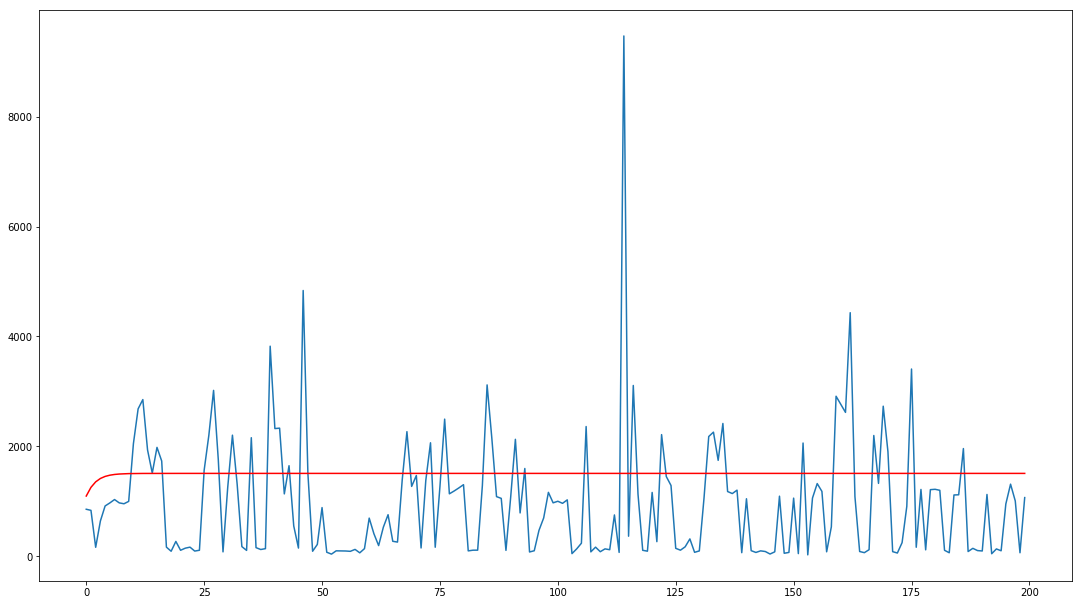

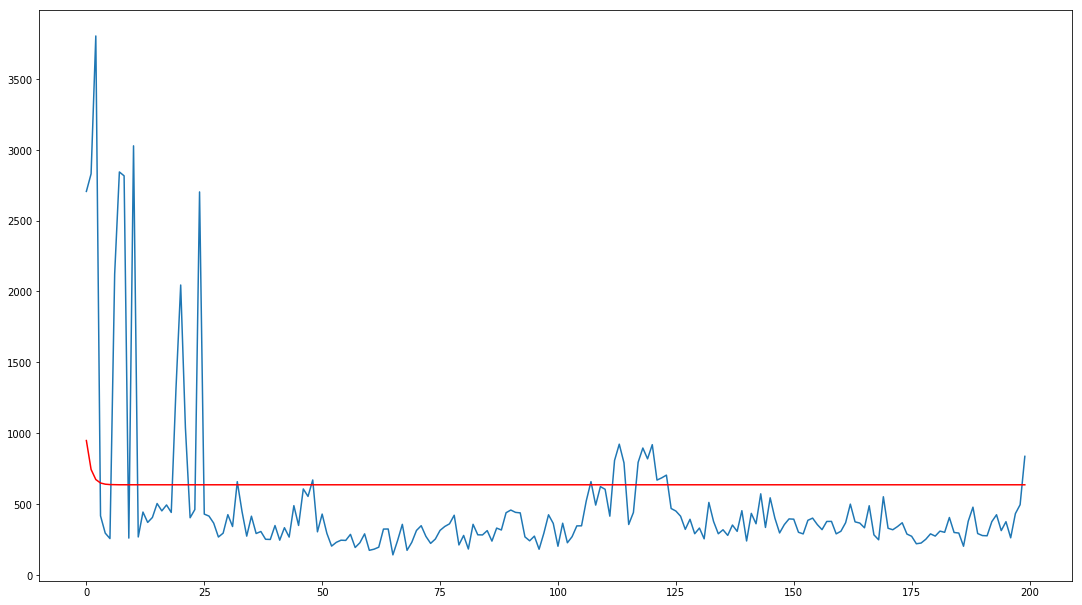

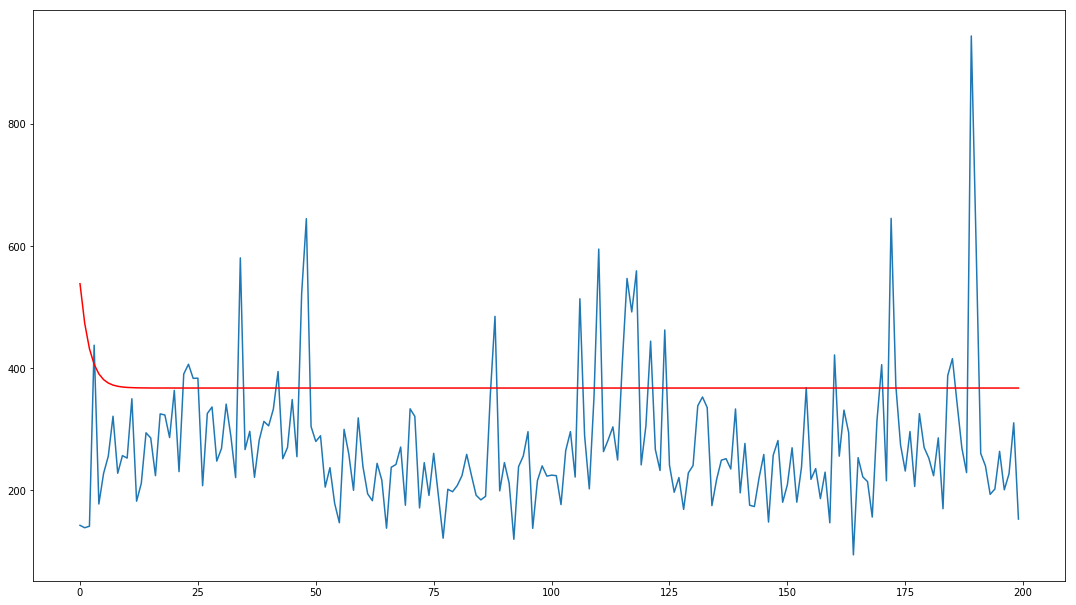

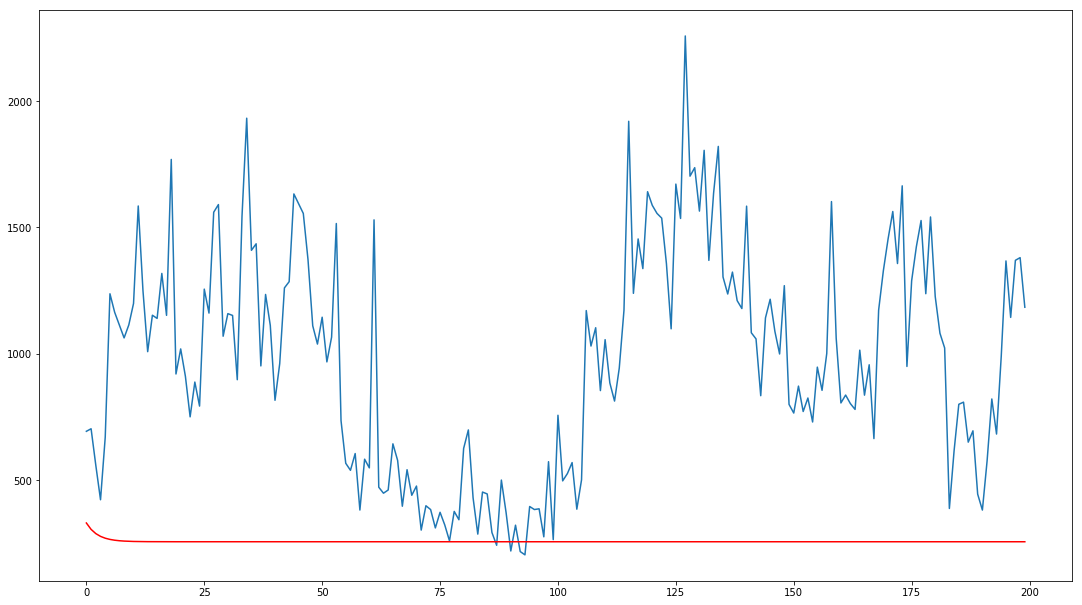

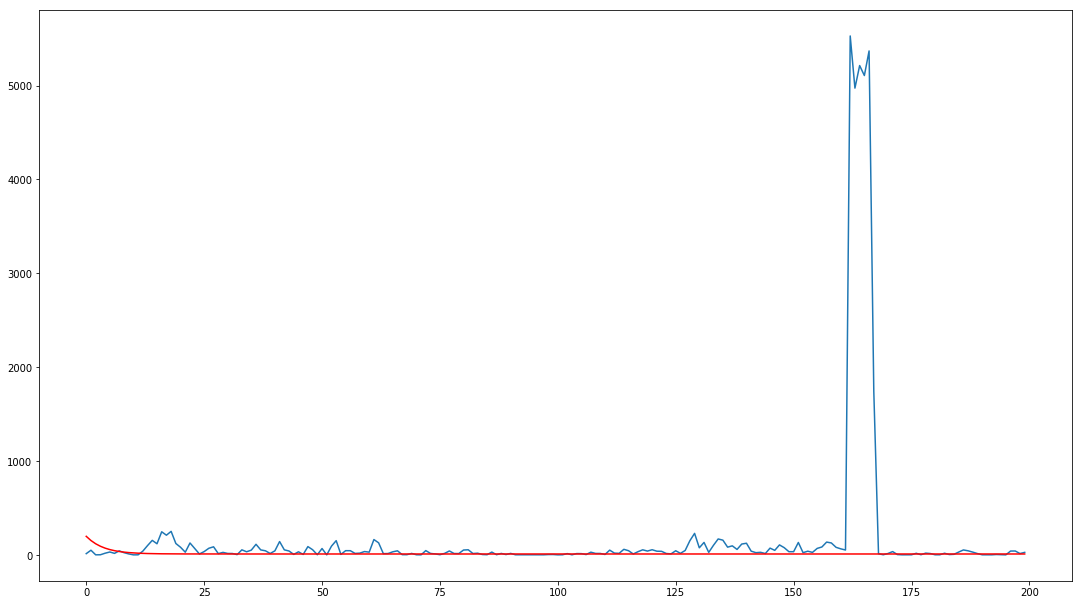

In [6]:
for x in range(0,5):
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    plt.plot(subsets_testing[x].values)
    plt.plot(LSTMpredictions[x], color = 'red')
    plt.show()

# Creating and fitting ARIMA

In [11]:
ARIMAmodels = []
ARIMApredictions = []
ARIMAconfInt = []
for x in range(0,1):
    # Fit a simple auto_arima model
    ARIMAmodel = pm.auto_arima(subsets_training[x].values.reshape(1,1000)[0], error_action='ignore', trace=1, seasonal=True, m=4)
    print(ARIMAmodel.get_params())
    # Create predictions for the future, evaluate on test
    pred, conf_int = ARIMAmodel.predict(n_periods=200, return_conf_int=True)
    ARIMAmodels.append(ARIMAmodel)
    ARIMApredictions.append(pred)
    ARIMAconfInt.append(conf_int)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 4); AIC=16761.896, BIC=16801.150, Fit time=1.919 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 4); AIC=17227.104, BIC=17236.917, Fit time=0.017 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 4); AIC=16992.525, BIC=17012.152, Fit time=0.107 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 4); AIC=16783.284, BIC=16802.911, Fit time=0.681 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 4); AIC=16758.938, BIC=16793.285, Fit time=1.608 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 4); AIC=16757.524, BIC=16786.964, Fit time=1.060 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 4); AIC=16754.307, BIC=16778.841, Fit time=1.073 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 4); AIC=16774.029, BIC=16793.656, Fit time=0.534 seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 0, 0, 4); AIC=16780.305, BIC=16809.745, Fit time=0.208 seconds
Fit ARIMA: order=(0

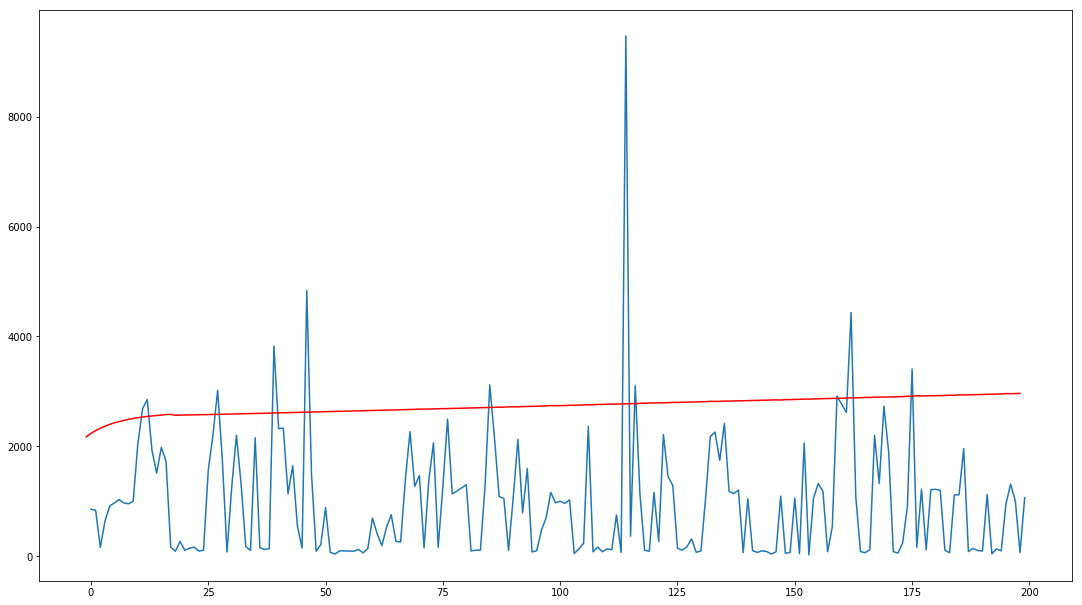

IndexError: list index out of range

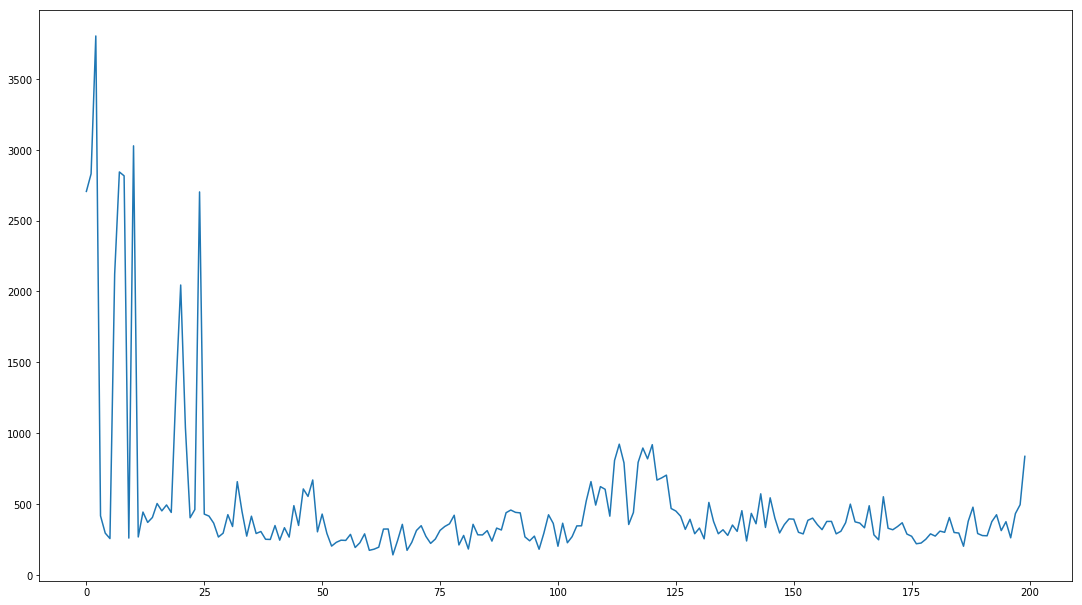

In [12]:
for x in range(0,5):
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    plt.plot(subsets_testing[x].values)
    plt.plot(range(-1,199), ARIMApredictions[x], color = 'red')
    plt.show()

In [ ]:
for x in range(0,5):
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    plt.plot(subsets_testing[x].values)
    plt.plot(range(-1,199), ARIMApredictions[x], color = 'red')
    plt.plot(LSTMpredictions[x], color = 'green')
    plt.show()

In [ ]:
OverallARIMAError = []
OverallLSTMError = []
for x in range(0,5):
    LSTMError = []
    ARIMAError = []
    for step in range(0,198):
        LSTMError.append(abs(LSTMpredictions[x][step][0] - subsets_testing[x].values[step][0]))
        ARIMAError.append(abs(ARIMApredictions[x][step+1][0] - subsets_testing[x].values[step][0]))
    OverallARIMAError.append(ARIMAError)
    OverallLSTMError.append(LSTMError)
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    plt.plot(ARIMAError, color = 'red')
    plt.plot(LSTMError, color = 'green')
    plt.show()

In [ ]:
for x in range(0,5):
    fig, axs = plt.subplots(1,2, sharey=True)
    fig.set_size_inches(18.5, 10.5)
    axs[0].boxplot(OverallARIMAError[x])
    axs[1].boxplot(OverallLSTMError[x])
    plt.show()